# **Learning About: ML Attack**
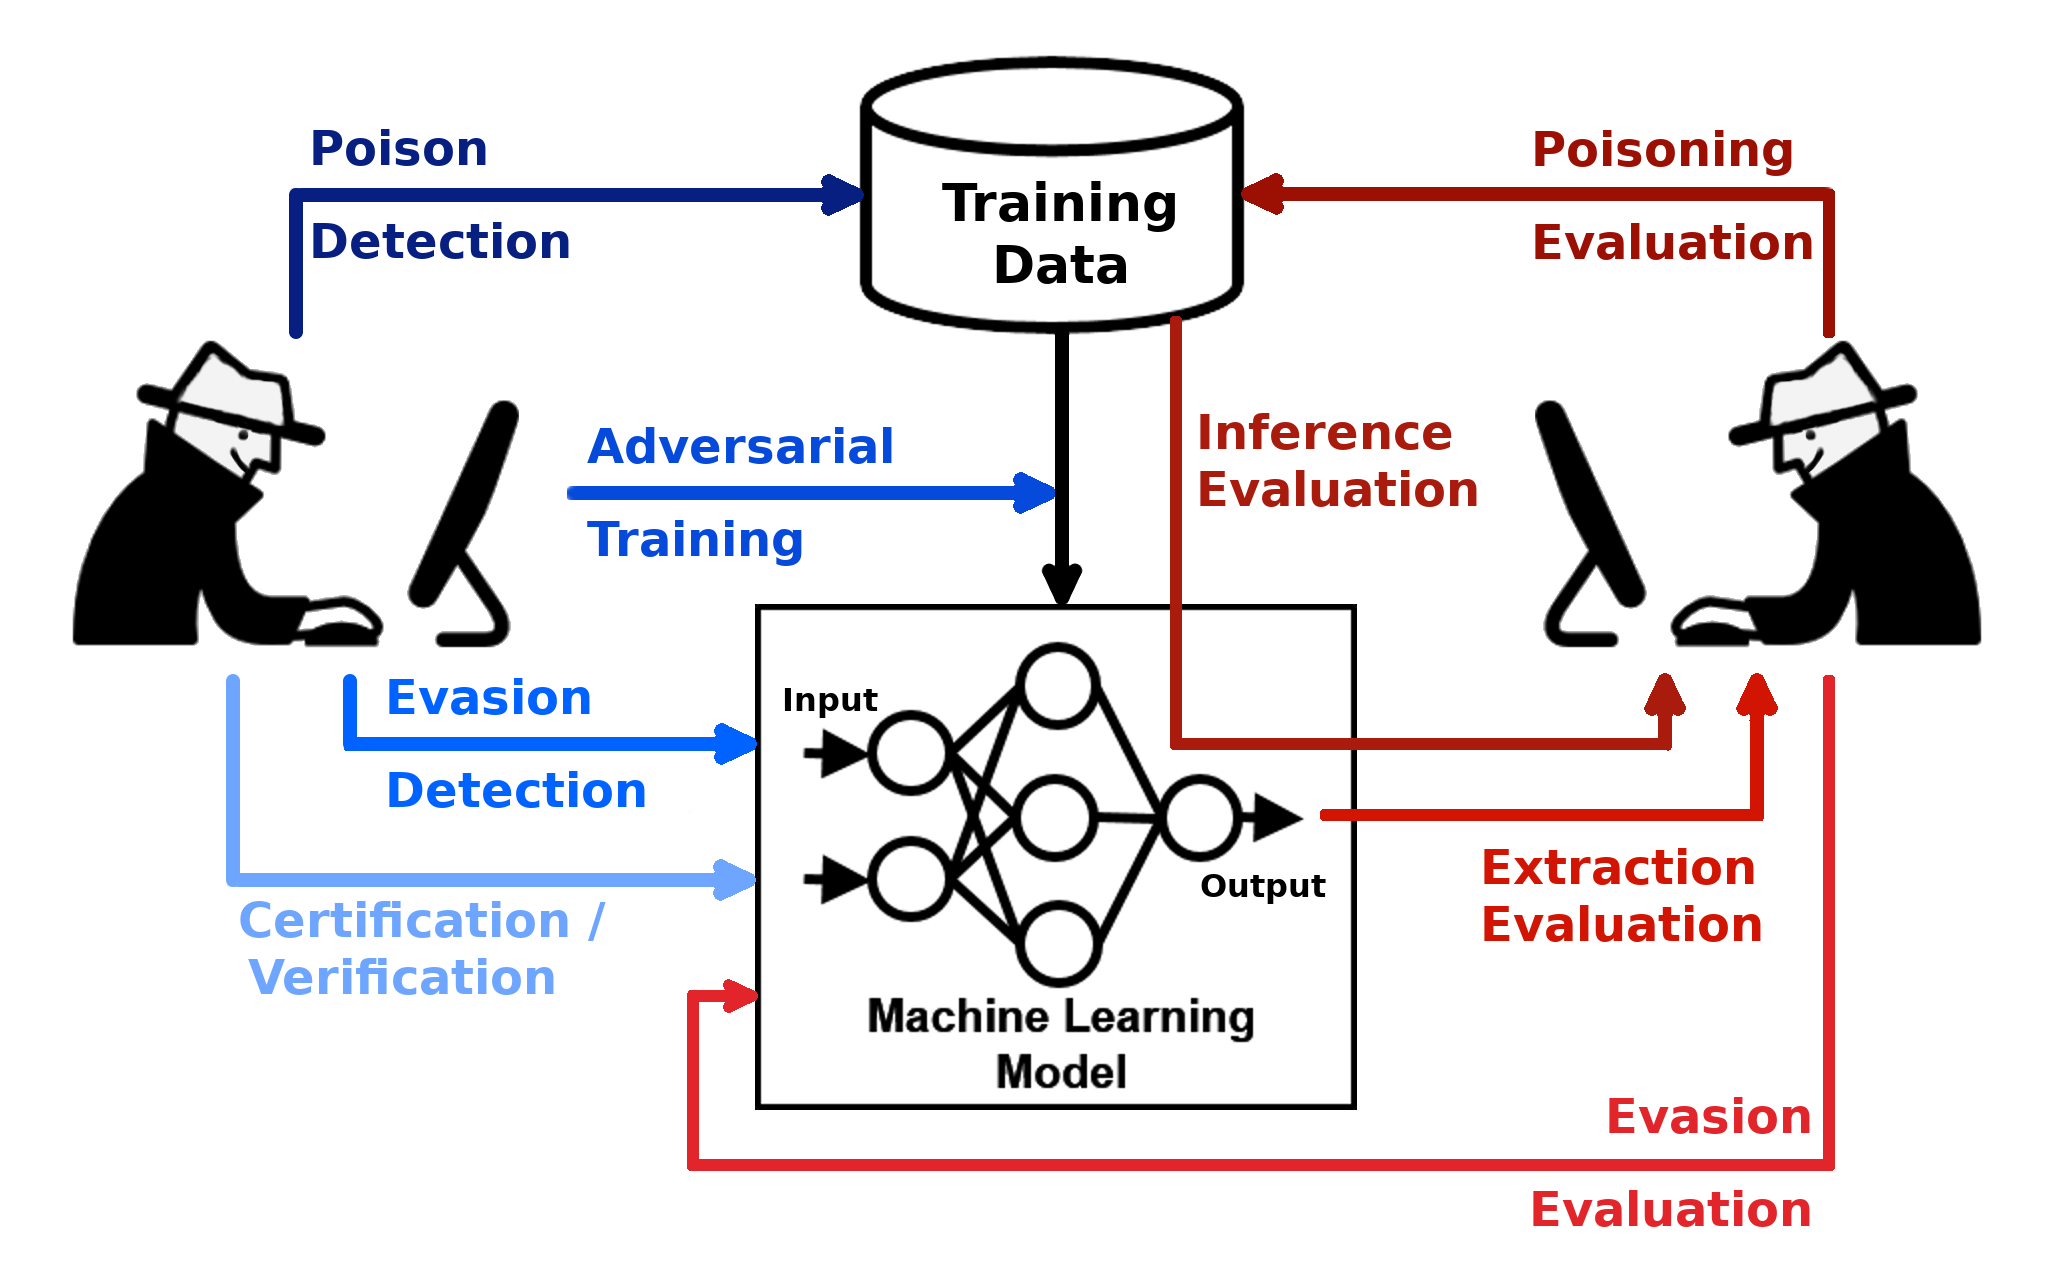

There are four main types of attacks for ML models:

- Evasion: perturbing the input data so that a trained model misclassifies it. Evasion is performed after training and during inference, that is, when models are already deployed in production. Adversaries perform evasion attacks to avoid detection by artificial intelligence systems. For example, hackers might perform an evasion attack to make the victim model fail to detect phishing emails. Evasion attacks might require access to the victim model.

- Extraction: an adversary attempts to construct a model that is similar or identical to a victim model. Simply put, extraction is the attempt to copy or steal a machine learning model. Extraction attacks typically require access to the original model as well as to data similar or identical to that originally used to train the victim model.

- Inference: generally aim to reconstruct part or the entire dataset used to train the victim model. Adversaries may use inference attacks to reconstruct entire training samples, separate features, or determine whether a sample was used to train the victim model.Inference attacks typically require access to the victim model.In some cases, attackers may also need access to some parts of the data used to train the model.

- Poisoning: they aim to disrupt the training data to corrupt the victim model during training.The "poisoned" data contains features (called backdoors) that trigger the desired output in a trained model. In essence, the perturbed features cause the model to overfit to them.As a very simple example (which we will see in the code below), a malicious user might poison the digits in the MNIST dataset so that the victim model classifies all digits as 9.Poisoning attacks require access to a model's training data before the actual training takes place.

Adversaries typically need some form of access to the machine learning model or its training data to perform an attack. But assuming your model is hosted in an environment that an adversary cannot reach, how do ML pipeline attacks occur?

Here are just a few of the cases where adversaries can gain access to the pipeline and data:

- Using a dataset from an unverified source. An adversary might poison the data and publish it somewhere for unsuspecting teams to use.Datasets from unreliable sources or unverified datasets run a higher risk of being compromised.

- Using a model from an unverified source.Similar to training data, attackers can publish models that victims can use.They can then use their knowledge of the model to launch attacks against it. Models from suspicious sources could also be pre-trained on poisoned data.

- Using a publicly available model. Suppose you are using a Hugging Face NLP model, which are in the public domain.An adversary could analyze a publicly available model and use its knowledge to attack other similar models used by other teams. In fact, it is not necessary for adversaries to have exactly the same model as you: knowledge of a model that performs the same task as you may be sufficient for an attack.

- An adversary has access to the ML pipeline. If a malicious insider is able to gain access to your pipeline, for example by exploiting their position in the organization, they may gain in-depth knowledge of its architecture, weights, and training data. They may also know the measures you use to protect your model, which probably makes malicious insiders the biggest threat to ML pipeline security.

In [ ]:
!pip install adversarial-robustness-toolbox

# **Evasion Attacks**

In [ ]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [ ]:
# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

In [ ]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [ ]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images,
    y=train_labels,
    epochs=10,
    batch_size=256)

In [ ]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,
    clip_values=(min, max)
    )

In [ ]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.3
    )

In [ ]:
# Generating adversarial images from test images
test_images_adv = attack_fgsm.generate(x=test_images)

In [ ]:
# Viewing an adversarial image
plt.imshow(X=test_images_adv[0])

In [ ]:
# Viewing an adversarial image
plt.imshow(X=test_images[0])

In [ ]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

In [ ]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
            axis=0)
            ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

# **Extraction Attacks**

In [ ]:
# Importing CopycatCNN
from art.attacks.extraction import CopycatCNN

# Setting aside a subset of the source dataset for the original model
train_images_original = train_images[:50000]
train_labels_original = train_labels[:50000]

# Using the rest of the source dataset for the stolen model
train_images_stolen = train_images[50000:]
train_labels_stolen = train_labels[50000:]

In [ ]:
# Training the original model on its training subset
model_original = create_model()
model_original.fit(
    x=train_images_original,
    y=train_labels_original,
    epochs=10,
    batch_size=256
)

In [ ]:
# Wrapping the model in the ART KerasClassifier class
classifier_original = KerasClassifier(
    model=model_original,
    clip_values=(min, max))

In [ ]:
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=len(train_images_stolen),
    classifier=classifier_original
    )

In [ ]:
# Creating a reference model for theft
model_stolen = KerasClassifier(
    model=create_model(),
    clip_values=(min, max)
    )

In [ ]:
# Extracting a thieved classifier
# by training the reference model
stolen_classifier = copycat_cnn.extract(
    x=train_images_stolen,
    y=train_labels_stolen,
    thieved_classifier=model_stolen
    )

In [ ]:
# Testing the performance of the original classifier
score_original = classifier_original._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} "
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

In [ ]:
# Defining subsets to try
data_subsets_to_try = [2500, 5000, 7500, 10000]

# Initializing a dict to store scores
scores = {}

# Iterating over each data subset
for data_subset in data_subsets_to_try:
    # Creating a reference model for theft
    model_stolen = KerasClassifier(
        model=create_model(),
        clip_values=(0, 1)
        )

    # Creating the "neural net thief" object
    # to train with the current subset size
    copycat_cnn = CopycatCNN(
        batch_size_fit=256,
        batch_size_query=256,
        nb_epochs=20,
        nb_stolen=data_subset,
        classifier=classifier_original
    )

    # Extracting a thieved classifier,
    # using a subset of the stolen data
    stolen_classifier = copycat_cnn.extract(
        x=train_images_stolen[:data_subset],
        y=train_labels_stolen[:data_subset],
        thieved_classifier=model_stolen
        )

    # Calculating test metrics for the current stolen model
    scores[data_subset] = stolen_classifier._model.evaluate(
        x=test_images,
        y=test_labels
    )

In [ ]:
# Converting the dict values to a Python list
score_values = list(scores.values())

# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test loss for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values[i][0]
        )

# Setting a title for the figure and showing it
plt.title(label="Test loss of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test loss")
plt.show()

In [ ]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Test accuracy of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()

# **Inference Attacks**

In [ ]:
# Importing dependencies
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=classifier,
    max_iter=2500,
    batch_size=256)

In [ ]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

In [ ]:
# Defining an initialization array for model inversion
x_init_average = np.zeros(shape=(10, 28, 28, 1)) + np.mean(a=test_images, axis=0)

In [ ]:
# Checking class gradients
class_gradient = classifier.class_gradient(
    x=x_init_average,
    label=y
    )

# Reshaping class gradients
class_gradient = np.reshape(
    a=class_gradient,
    newshape=(10, 28*28)
    )

# Obtaining the largest gradient value for each class
class_gradient_max = np.max(class_gradient, axis=1)

# Inspecting class gradients
print(class_gradient_max)

In [ ]:
%%time

# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average,
    y=y
    )

In [ ]:
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()

# **Poisoning Attacks**

In [ ]:
# Importing dependencies
from art.utils import to_categorical
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)

# Defining a target label for poisoning
target = to_categorical(
    labels=np.repeat(a=5, repeats=5),
    nb_classes=10
    )

# Inspecting the target labels
print(f"The target labels for poisoning are\n {target}")

In [ ]:
from art.utils import load_dataset

# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

poisoned_images, poisoned_labels = backdoor.poison(
    x=train_images[:5],
    y=target
    )

In [ ]:
import matplotlib.pyplot as plt

# Creating a figure and axes for the poisoned images
fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    squeeze=True,
    figsize=(15, 5)
    )

# Plotting the poisoned images
for i in range(len(poisoned_images)):
    axes[i].imshow(X=poisoned_images[i])
    axes[i].set_title(label=f"Label: {np.argmax(poisoned_labels[i])}")
    axes[i].set_xticks(ticks=[])
    axes[i].set_yticks(ticks=[])

# Showing the plot
plt.show()


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from art.estimators.classification import KerasClassifier

# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

# Instantiating the model
model = create_model()

# Training the model
#model.fit(
#    x=train_images,
#    y=train_labels,
#    epochs=10,
#    batch_size=256)

# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,
    clip_values=(min, max)
    )

# Defining a target label for poisoning
target = to_categorical(
    labels=[9],
    nb_classes=10
    )[0]

# Defining a clean label backdoor attack
attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor,
    proxy_classifier=classifier,
    target=target,
    pp_poison=0.75,
    norm=2,
    eps=5,
    eps_step=0.1,
    max_iter=200)

In [ ]:
poisoned_images, poisoned_labels = attack.poison(
    x=train_images[:10000],
    y=train_labels[:10000]
    )

In [ ]:
# Getting the indices of the images
# whose target corresponds to our backdoor target
poisoned_indices = np.all(
        a=(poisoned_labels == target),
        axis=1
        )

# Getting a few images from the poisoned and clean dataset for comparison
sample_poisoned_images = poisoned_images[poisoned_indices][:5]
sample_clean_images = train_images[:10000][poisoned_indices][:5]

# Defining a number of rows and columns for the plot
nrows, ncols = 5, 2

# Creating a figure and axes
fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(10, 25)
        )

# Defining a counting variable
counter = 0

# Indicating the purpose of each column
axes[0, 0].set_title(
        label="Images from the poisoned dataset",
        pad=25
        )
axes[0, 1].set_title(
        label="Images from the clean dataset",
        pad=25
        )

# Iterating over the axis rows in our figure
for i in range(nrows):
        # Plotting the image from the poisoned dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 0].imshow(sample_poisoned_images[counter])
        axes[i, 0].set_xticks(ticks=[])
        axes[i, 0].set_yticks(ticks=[])


        # Plotting the image from the clean dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 1].imshow(sample_clean_images[counter])
        axes[i, 1].set_xticks(ticks=[])
        axes[i, 1].set_yticks(ticks=[])


        # Incrementing counter value
        counter += 1

# Showing the plot
plt.show()

In [ ]:
# Function for creating victim model
def create_victim_model():
    # Defining the model's architecture
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

    # Returning the model
    return model

In [ ]:
# Creating and training a victim classifier
# with the poisoned data
model_poisoned = create_victim_model()
model_poisoned.fit(
    x=poisoned_images,
    y=poisoned_labels,
    epochs=10
    )

In [ ]:
# Getting the indices of the test images whose target
# is different from the backdoor target
not_target = np.logical_not(np.all(
    a=test_labels == target,
    axis=1
    ))

# Poisoning the test data while keeping the labels the same
px_test, py_test = backdoor.poison(
    x=test_images[not_target],
    y=test_labels[not_target]
    )

In [ ]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(25, 10)
    )

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned test images
# along with their true targets
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"True label: {np.argmax(py_test[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1

In [ ]:
# Evaluating the poisoned classifier on clean test data
scores_clean = model_poisoned.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the poisoned classifier on poisoned test data
scores_poisoned = model_poisoned.evaluate(
    x=px_test,
    y=py_test
    )

# Comparing test losses
print(f"Clean test loss: {scores_clean[0]:.2f} "
      f"vs poisoned test loss: {scores_poisoned[0]:.2f}")

# Comparing test accuracies
print(f"Clean test accuracy: {scores_clean[1]:.2f} "
      f"vs poisoned test accuracy: {scores_poisoned[1]:.2f}")

In [ ]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(25, 10)
    )

# Getting predictions for the first ten poisoned images
poisoned_predictions = model_poisoned.predict(x=px_test[:10])

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"Prediction: {np.argmax(poisoned_predictions[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1